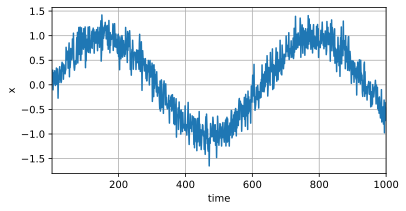

In [26]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
# !pip install d2l==0.17.0

In [7]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [9]:
features.shape, x.shape

(torch.Size([996, 4]), torch.Size([1000]))

In [10]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [11]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.085936
epoch 2, loss: 0.056705
epoch 3, loss: 0.054715
epoch 4, loss: 0.054509
epoch 5, loss: 0.053420


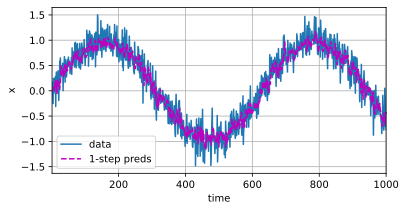

In [14]:
onestep_preds = net(features)
d2l.plot(X=[time, time[tau:]],
         Y=[x.detach().numpy(), onestep_preds.detach().numpy()], 
         xlabel='time',
         ylabel='x', 
         legend=['data', '1-step preds'], 
         xlim=[1, 1000],
         figsize=(6, 3))

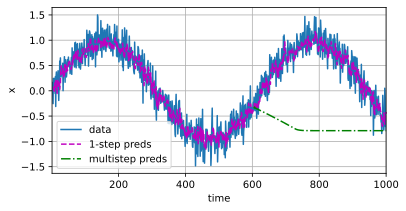

In [15]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot(X=[time, time[tau:], time[n_train + tau:]],
         Y=[x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()], 
         xlabel='time',
         ylabel='x', 
         legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [31]:
def build_features_and_xlabels(step):
    features = torch.zeros((997-step, 4))
    for i in range(4):
        features[:, i] = x[i: i+997-step]
    labels = x[step+3:].reshape((-1, 1))
    return features, labels, time[step+3:]

In [52]:
def get_pred(features, labels):
    print(features.shape, labels.shape)
    train_iter = d2l.load_array(
        (features[:n_train], labels[:n_train]),
        batch_size, is_train=True
    )

    def get_net():
        net = torch.nn.Sequential(
            nn.Linear(4, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        net.apply(init_weights)
        return net
    
    net = get_net()
    train(net, train_iter, nn.MSELoss(reduction='none'), epochs=5, lr=0.01)
    preds = net(features)
    return preds.detach().numpy()
    

torch.Size([996, 4]) torch.Size([996, 1])
epoch 1, loss: 0.054065
epoch 2, loss: 0.055398
epoch 3, loss: 0.051119
epoch 4, loss: 0.051104
epoch 5, loss: 0.052202
torch.Size([933, 4]) torch.Size([933, 1])
epoch 1, loss: 0.234303
epoch 2, loss: 0.235525
epoch 3, loss: 0.224524
epoch 4, loss: 0.222454
epoch 5, loss: 0.221418


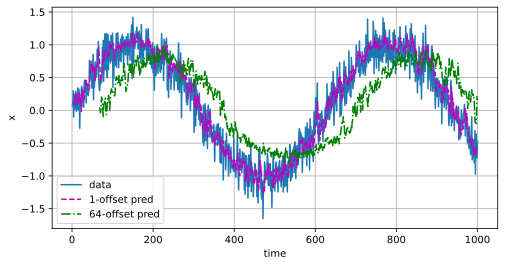

In [53]:
xs, ys = [time], [x]
step4plot = [1, 64]
for step in step4plot:
    tmp_features, tmp_labels, tmp_time = build_features_and_xlabels(step)
    xs.append(tmp_time)
    ys.append(get_pred(tmp_features, tmp_labels))

d2l.plot(
    xs, ys,
    xlabel='time',
    ylabel='x',
    legend=['data']+[f'{step}-offset pred' for step in step4plot],
    figsize=(8, 4)
)

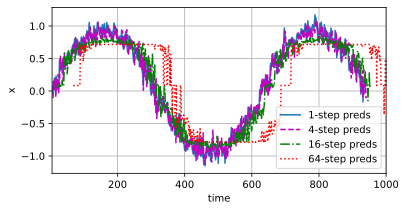

In [19]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))